In [4]:
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

import processing_io as pio
import sys
import os
import joblib
import json

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch_geometric.data import Data, Batch
import torch
from torch_geometric.data import Data
import alphashape
from matplotlib.lines import Line2D

from shapely.geometry import Polygon
from torch.utils.data import DataLoader, Dataset, Subset


districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

# Add the 'scripts' directory to the Python path
scripts_path = os.path.abspath(os.path.join('..'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

import gnn_io as gio
import gnn_architectures as garch
import help_functions as hf

import copy

def replace_invalid_values(tensor):
    tensor[tensor != tensor] = 0  # replace NaNs with 0
    tensor[tensor == float('inf')] = 0  # replace inf with 0
    tensor[tensor == float('-inf')] = 0  # replace -inf with 0
    return tensor

In [17]:
run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_optimized/pnc_local_[128]_pnc_global_[256_128]_hidden_layer_str_[128_256_512_256_128_64]_dropout_0.3_use_dropout_False/'
point_net_conv_layer_structure_local_mlp = [128]
point_net_conv_layer_structure_global_mlp = [256, 128]
gat_conv_layer_structure = [128,256,512,256,128,64]
dropout = 0.3
use_dropout = False 
in_channels = 6 
out_channels = 1 

districts_of_interest = [1, 2, 3, 4]
zone_to_plot = "zone_1"
test_data = "../../data/test_data/gdf_pop_1pm_policy_in_1_2_3_4.geojson"
test_data = gpd.read_file(test_data)
base_case = "../../data/test_data/gdf_basecase_mean_pop_1pm.geojson"
base_case = gpd.read_file(base_case)    
    
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
indices_of_datasets_to_use = [0, 1, 3, 4]

scaler_x = joblib.load(data_created_during_training + 'x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'pos_scaler.pkl')

In [18]:


# Initialize the model
model = garch.MyGnn(in_channels=in_channels, out_channels=out_channels, 
                    point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                    point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                    gat_conv_layer_structure=gat_conv_layer_structure,
                    dropout=dropout,
                    use_dropout=use_dropout)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Initializing PointNetConv(local_nn=Sequential(
  (0): Linear(in_features=6, out_features=128, bias=True)
  (1): ReLU()
), global_nn=Sequential(
  (0): Linear(in_features=128, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
))
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 1.weight with kaiming_normal
Initializing 1.bias with zeros
Initializing 3.weight with kaiming_normal
Initializing 3.bias with zeros
Initializing Linear(in_features=6, out_features=128, bias=True)
Initializing Linear(in_features=128, out_features=256, bias=True)
Initializing Linear(in_features=256, out_features=128, bias=True)
Initializing Linear(in_features=128, out_features=128, bias=True)
Initializing GATConv(128, 256, heads=1)
Initializing GATConv(256, 512, heads=1)
Initializin

In [19]:
test_input_linegraph = pio.create_test_data_object(base_case=base_case, test_data = test_data) # check this function if there have been changes in the features of the data
test_data_list = [test_input_linegraph] # we do it for just one test data object, for now.
dataset_only_relevant_dimensions = gio.cut_dimensions(dataset=test_data_list, indices_of_dimensions_to_keep=indices_of_datasets_to_use)
test_subset = Subset(dataset_only_relevant_dimensions[0], 0)

In [20]:
test_input_linegraph.y

tensor([[-0.1741],
        [-1.2481],
        [-0.8000],
        ...,
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])

In [21]:
def normalize_one_dataset_given_scaler(dataset_input, x_scalar_list = None, pos_scalar=None, y_scalar=None, normalize_y=False):
    dataset = normalize_x_values_given_scaler(dataset_input, x_scalar_list)
    dataset.pos = torch.tensor(pos_scalar.transform(dataset.pos.numpy()), dtype=torch.float)
    if normalize_y:
        dataset.y = torch.tensor(y_scalar.transform(dataset.y.numpy()), dtype=torch.float)
    return dataset

def normalize_x_values_given_scaler(dataset, x_scaler_list):
    for i in range(4):
        scaler = x_scaler_list[i]
        data_x_dim = replace_invalid_values(dataset.x[:, i].reshape(-1, 1))
        normalized_x_dim = torch.tensor(scaler.transform(data_x_dim.numpy()), dtype=torch.float)
        dataset.x[:, i]=  normalized_x_dim.squeeze()
    return dataset

In [22]:
dataset_normalized = normalize_one_dataset_given_scaler(dataset_input=test_subset.dataset, x_scalar_list=scaler_x, pos_scalar=scaler_pos, y_scalar=None, normalize_y=False)
test_dl = gio.create_dataloader(dataset=dataset_normalized, is_train=False, batch_size=8, train_ratio=0, is_test=True)

In [25]:
loss_fct = torch.nn.MSELoss()
test_loss, r_squared, actual_vals, predictions = hf.validate_one_model(model, dataset_normalized, loss_fct, device)
print(f'Test Loss: {test_loss}')
print(f'r_squared: {r_squared}')

Test Loss: 0.925759494304657
r_squared: -0.7202262878417969


/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:275: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(buffer)


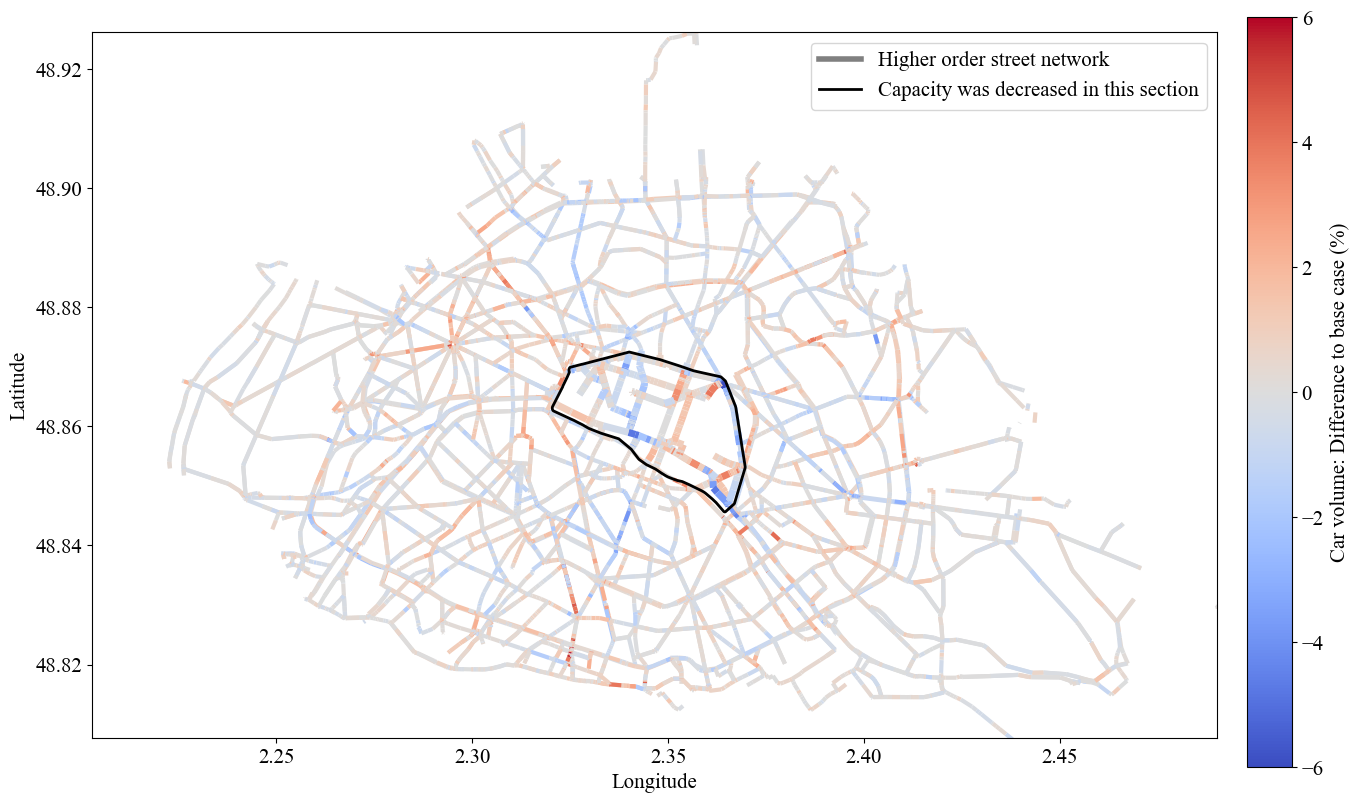

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:275: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(buffer)


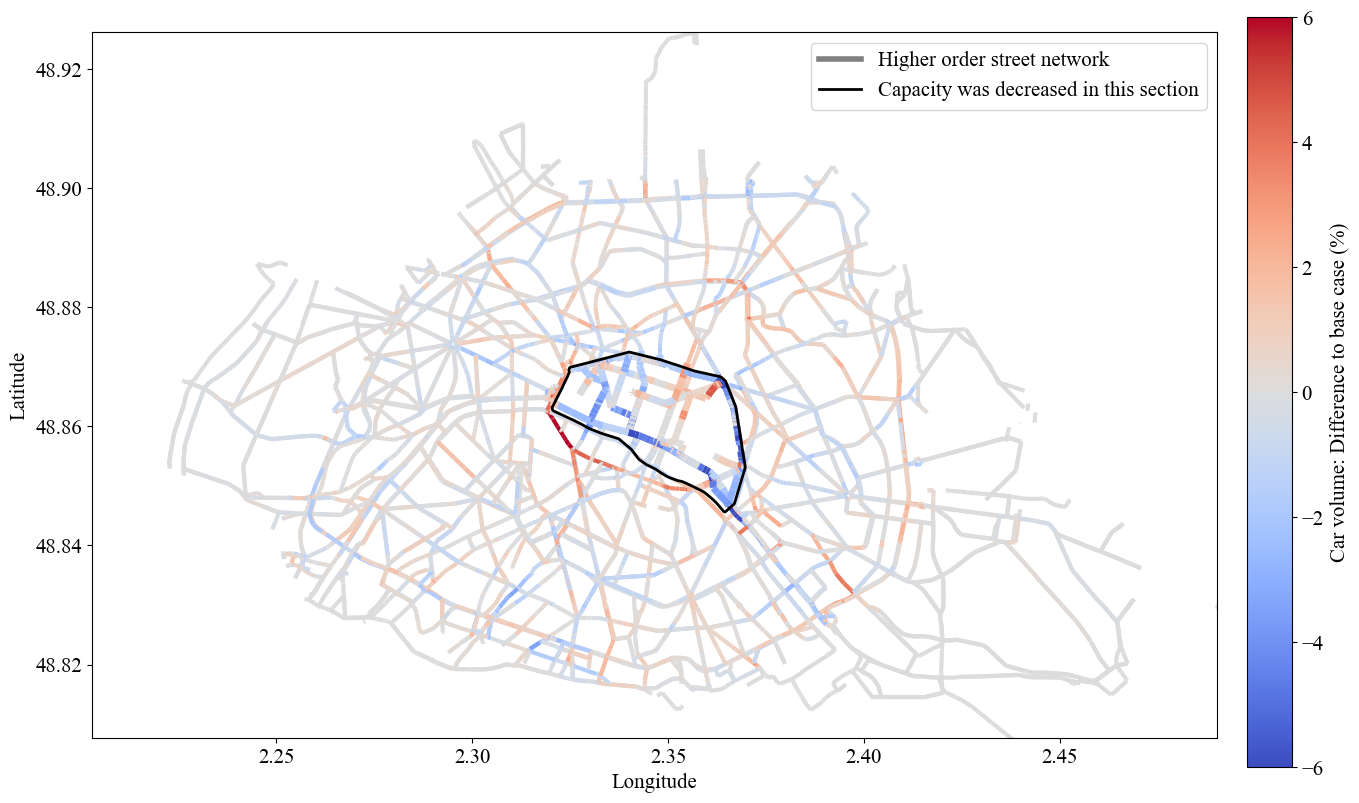

/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/scripts/testing_and_evaluation/help_functions.py:275: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_target_districts['geometry'] = buffered_target_districts.buffer(buffer)


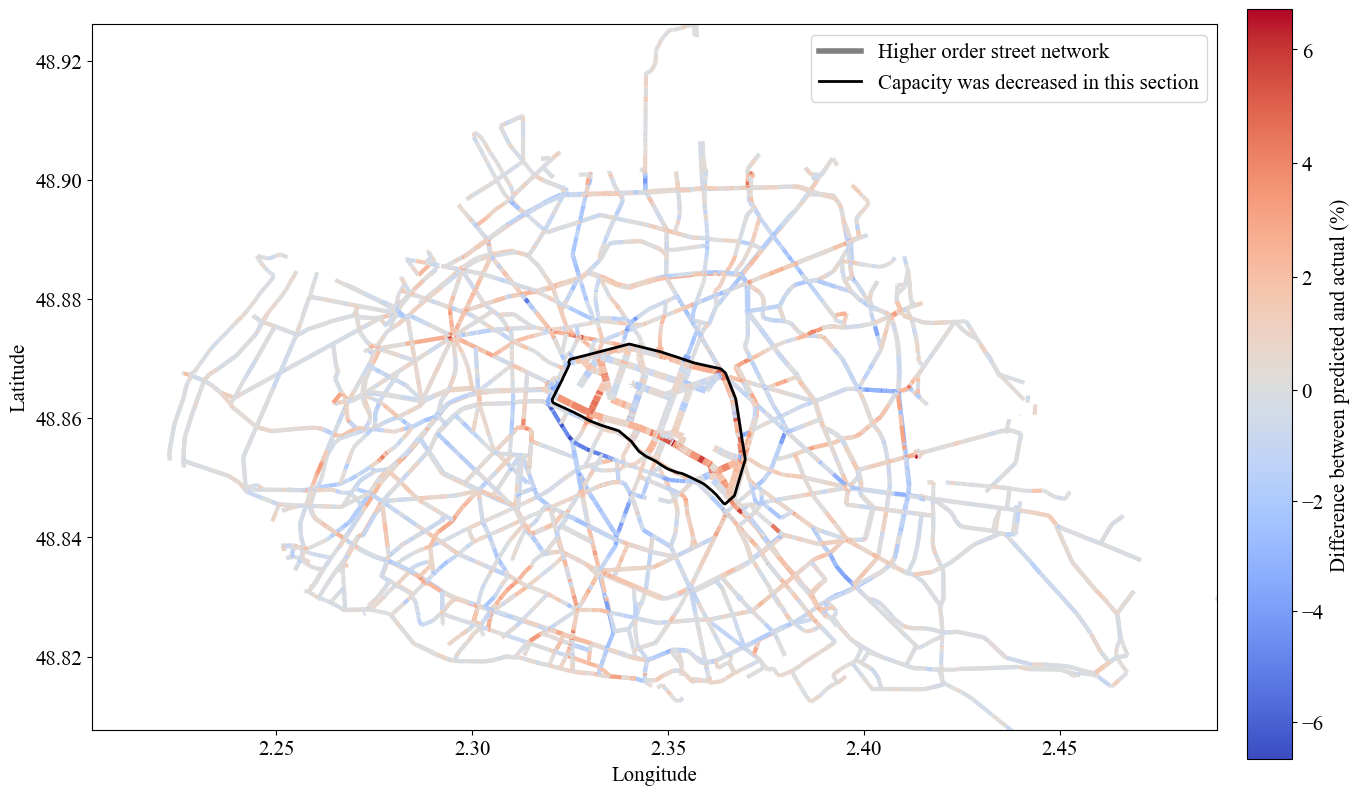

In [26]:
i = 0
gdf = hf.data_to_geodataframe(data=test_dl.dataset, original_gdf=test_data, predicted_values=predictions)
gdf_with_og_values = hf.map_to_original_values(input_gdf=gdf, scaler_x =scaler_x)
hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_predicted", 
                        save_it=True, number_to_plot=None, zone_to_plot = zone_to_plot, is_predicted=True, alpha=0, use_fixed_norm=True, 
                        fixed_norm_max = 6,
                        known_districts = True, buffer = 0.0005, districts_of_interest=districts_of_interest)
hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_actual", save_it=True, 
                        number_to_plot=None, zone_to_plot = zone_to_plot,is_predicted=False,alpha=10,use_fixed_norm=True, 
                        fixed_norm_max = 6,
                        known_districts = True, buffer = 0.0005, districts_of_interest=districts_of_interest)
hf.plot_difference_output(gdf_input=gdf_with_og_values, column1="og_vol_car_change_predicted", 
                          column2="og_vol_car_change_actual", save_it=True, number_to_plot=None, zone_to_plot = zone_to_plot,
                        alpha=10,use_fixed_norm=False, 
                        fixed_norm_max = 6,
                        known_districts = True, buffer = 0.0005, districts_of_interest=districts_of_interest)